In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
# import MySQLdb as mdb
# from definitions import DATABASE_CONFIG_DIR, INCOME_STATEMENT_DIR

## load stock info

In [3]:
with open('../../database/database_config/database.ymal') as f:
    db_config = yaml.load(f, Loader=yaml.FullLoader)
db = mdb.connect(host=db_config['db_host'], user=db_config['db_user'], passwd=db_config['db_pass'],
                 db=db_config['db_name'], use_unicode=True, charset="utf8")
# select stockId and ticker from table stock_info
table_name = 'stock_info'
column_list = ['stockId', 'ticker', 'IndustryGroup']
columns = ','.join(column_list)
req = """SELECT %s FROM %s WHERE sp500=TRUE """ % (columns, table_name)
get_stock_info_cursor = db.cursor()
get_stock_info_cursor.execute(req)
stock_info = get_stock_info_cursor.fetchall()
get_stock_info_cursor.close()

#create dataframe
df_stock_info = pd.DataFrame(stock_info, columns=column_list)

FileNotFoundError: [Errno 2] No such file or directory: '../../database/database_config/database.ymal'

In [3]:
df_stock_info.head(5)

,stockId,ticker,IndustryGroup
0,11,PNR,Machinery
1,37,ALLE,Building Materials
2,45,ITW,Machinery
3,48,AMAT,Semiconductor Equip
4,52,NWL,Household Products


## load the file

In [4]:
file = '../20210315_valuation_result.csv'
df_valuation = pd.read_csv(file)

In [5]:
df_valuation.head(5)

,ticker,current_price,estimated_value,price_to_value
0,PNR,59.450,35.352727,1.681624
1,ALLE,116.450,80.469651,1.447129
2,ITW,214.910,154.809823,1.388219
3,AMAT,115.130,104.682096,1.099806
4,NWL,25.135,14.159187,1.775173


In [6]:
df_valuation.describe()

,current_price,estimated_value,price_to_value
count,500.000000,498.000000,498.000000
mean,177.955671,-1663.688549,1.038396
std,320.845772,26280.176278,18.562622
min,11.760000,-460520.985894,-187.391079
25%,58.587500,20.892830,0.731202
50%,107.927500,65.426237,1.321168
75%,188.023500,127.434980,2.112528
max,4525.000000,16134.444236,164.972774


## merge two dataframes

In [7]:
df = pd.merge(df_valuation, df_stock_info, left_on='ticker', right_on='ticker', how='left')

In [8]:
## filter out finanace sector 
df = df.loc[(df['IndustryGroup']!='Financial Svcs. (Non-bank & Insurance)')
                 & (df['IndustryGroup']!='Banks (Regional)') 
                 & (df['IndustryGroup']!='Bank (Money Center)') 
                 & (df['IndustryGroup']!='Brokerage & Investment Banking') 
                 & (df['IndustryGroup']!='Investments & Asset Management') 
                 & (df['IndustryGroup']!='Insurance (Life)')
                 & (df['IndustryGroup']!='Insurance (Prop/Cas.)')
                 & (df['IndustryGroup']!='Insurance (General)')]

## EDA

array([[<AxesSubplot:title={'center':'price_to_value'}>]], dtype=object)

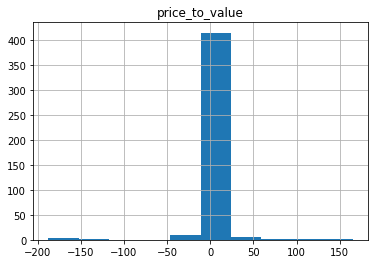

In [9]:
df.hist(column="price_to_value")

### calculate the range

In [10]:
def cut_to(x):
    if x<0:
        return 'less than 0'
    elif x<1:
        return '0-1'
    else:
        return 'larger than 1'

df['valuation_range'] = df['price_to_value'].map(cut_to)

In [11]:
df

,ticker,current_price,estimated_value,price_to_value,stockId,IndustryGroup,valuation_range
0,PNR,59.4500,35.352727,1.681624,11,Machinery,larger than 1
1,ALLE,116.4500,80.469651,1.447129,37,Building Materials,larger than 1
2,ITW,214.9100,154.809823,1.388219,45,Machinery,larger than 1
3,AMAT,115.1300,104.682096,1.099806,48,Semiconductor Equip,larger than 1
4,NWL,25.1350,14.159187,1.775173,52,Household Products,larger than 1
...,...,...,...,...,...,...,...
500,UAL,55.5506,-1594.061325,-0.034848,9772,Air Transport,less than 0
501,CDW,159.1500,104.903001,1.517116,9829,Computer Services,larger than 1
502,MU,87.0082,186.525600,0.466468,9839,Semiconductor,0-1
503,DLTR,107.9450,117.833124,0.916084,9850,Retail (General),0-1


In [12]:
df['valuation_range'].value_counts()

larger than 1    304
0-1               75
less than 0       64
Name: valuation_range, dtype: int64

## sort

In [13]:
df.sort_values(by=['price_to_value'])

,ticker,current_price,estimated_value,price_to_value,stockId,IndustryGroup,valuation_range
125,HOLX,70.450,-0.375952,-187.391079,2317,Healthcare Products,less than 0
5,MAA,139.690,-0.821716,-169.997865,54,R.E.I.T.,less than 0
346,DD,77.030,-0.461416,-166.942705,6448,Chemical (Specialty),less than 0
89,REG,58.315,-0.422219,-138.115569,1651,R.E.I.T.,less than 0
12,GPN,213.940,-7.807617,-27.401447,149,Information Services,less than 0
...,...,...,...,...,...,...,...
156,ODFL,NaN,NaN,NaN,2913,Trucking,larger than 1
250,BMY,NaN,NaN,NaN,4648,Drugs (Pharmaceutical),larger than 1
262,HRL,NaN,NaN,NaN,4767,Food Processing,larger than 1
342,BSX,38.935,NaN,NaN,6318,Healthcare Products,larger than 1


### select the valuation between 0-1

In [14]:
df = df.loc[df['valuation_range'] == '0-1']
df = df.sort_values(by=['price_to_value'])

array([[<AxesSubplot:title={'center':'price_to_value'}>]], dtype=object)

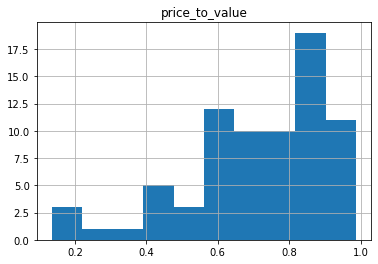

In [15]:
df.hist(column="price_to_value")

In [16]:
df.head(10)

,ticker,current_price,estimated_value,price_to_value,stockId,IndustryGroup,valuation_range
138,HLT,125.6000,928.581609,0.135260,2632,Hotel/Gaming,0-1
14,MAR,150.5300,1036.427525,0.145239,151,Hotel/Gaming,0-1
58,BKNG,2384.1200,16134.444236,0.147766,1196,Retail (Online),0-1
72,FOX,40.1300,161.585996,0.248351,1370,empty,0-1
431,RL,123.8900,338.938647,0.365523,8292,Apparel,0-1
188,DISCA,70.9500,179.990027,0.394189,3488,empty,0-1
362,DHI,81.4700,186.927851,0.435837,6698,Homebuilding,0-1
53,PHM,48.1150,104.730680,0.459416,1120,Homebuilding,0-1
275,FOXA,42.7800,92.944763,0.460273,5061,Broadcasting,0-1
502,MU,87.0082,186.525600,0.466468,9839,Semiconductor,0-1


In [17]:
df.loc[(df['price_to_value']>0.6) & (df['price_to_value']<0.8)]

,ticker,current_price,estimated_value,price_to_value,stockId,IndustryGroup,valuation_range
140,ABC,112.4110,186.629958,0.602320,2669,Healthcare Support Services,0-1
137,LB,60.2350,98.899051,0.609055,2566,Retail (Special Lines),0-1
35,HII,194.4100,314.914734,0.617342,680,Aerospace/Defense,0-1
237,HUM,403.5400,646.948582,0.623759,4408,Healthcare Support Services,0-1
479,DXC,29.1700,46.492635,0.627411,9425,Computer Services,0-1
405,FB,266.0600,423.728365,0.627902,7538,Software (Entertainment),0-1
334,IPG,29.5950,46.785842,0.632563,6158,Advertising,0-1
247,UHS,136.1300,213.589540,0.637344,4630,Hospitals/Healthcare Facilities,0-1
133,TSN,75.7900,117.560327,0.644690,2473,Food Processing,0-1
81,GOOG,2062.2300,3168.740126,0.650804,1547,empty,0-1
